<a href="https://colab.research.google.com/github/laribar/TechChallenge2/blob/main/TechChallenge_2_Rev01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [54]:
# Análise de dados e manipulação
import pandas as pd
import numpy as np

# Visualização de dados
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
# Manipulação de datas
from datetime import datetime
from pandas.tseries.offsets import BDay

# Verificação de versões (opcional)
import sklearn
print(f"Scikit-learn version: {sklearn.__version__}")



Scikit-learn version: 1.6.1


In [55]:
# Baixar dados do Ibovespa desde 1994
print("Baixando dados...")
df = yf.download('^BVSP', start='1994-07-01', end=datetime.now().strftime('%Y-%m-%d'))

# Verificar valores nulos
print("Valores nulos antes do preenchimento:")
print(df.isnull().sum())

# Pré-processamento
df = df.ffill()  # Preencher valores ausentes

[*********************100%***********************]  1 of 1 completed

Baixando dados...
Valores nulos antes do preenchimento:
Price   Ticker
Close   ^BVSP     0
High    ^BVSP     0
Low     ^BVSP     0
Open    ^BVSP     0
Volume  ^BVSP     0
dtype: int64


In [56]:
# Criar features
df['MA_7'] = df['Close'].rolling(window=7).mean()
df['MA_30'] = df['Close'].rolling(window=30).mean()
df['Volatility'] = df['Close'].pct_change().rolling(window=7).std()
df['Daily_Return'] = df['Close'].pct_change()
df['Log_Return'] = np.log(df['Close'] / df['Close'].shift(1))

# Bandas de Bollinger
df['BB_Mid'] = df['Close'].rolling(window=20).mean()
std_dev = df['Close'].rolling(window=20).std().squeeze()
df['BB_Upper'] = df['BB_Mid'] + (std_dev * 2)
df['BB_Lower'] = df['BB_Mid'] - (std_dev * 2)

# Índice de Força Relativa (RSI)
delta = df['Close'].diff(1)
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
df['RSI'] = 100 - (100 / (1 + rs))

# Remover valores nulos remanescentes
df.dropna(inplace=True)
print("Dados após dropna:", len(df))

Dados após dropna: 7560


In [58]:
# Definir variáveis preditoras e alvo
X = df.drop(columns=['Close'])
y = df['Close']

# Validação com TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)
for train_idx, test_idx in tscv.split(X):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

# Treinar modelo de Regressão Linear
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
linear_predictions = linear_model.predict(X_test)

# Treinar modelo de Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)

# Treinar modelo ARIMA
arima_model = ARIMA(y_train, order=(5,1,0))
arima_model_fit = arima_model.fit()
arima_predictions = arima_model_fit.forecast(steps=len(y_test))

# Treinar modelo SARIMA
sarima_model = SARIMAX(y_train, order=(5,1,0), seasonal_order=(1,1,1,12))
sarima_model_fit = sarima_model.fit()
sarima_predictions = sarima_model_fit.forecast(steps=len(y_test))

# Comparação com modelo ingênuo
naive_predictions = y_test.shift(1).fillna(method="bfill")
naive_rmse = np.sqrt(mean_squared_error(y_test, naive_predictions))
print(f"RMSE do modelo ingênuo: {naive_rmse}")


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_date

RMSE do modelo ingênuo: 1600.9107849189602


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
<ipython-input-58-2b88152e5b34>:32: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  naive_predictions = y_test.shift(1).fillna(method="bfill")


In [59]:
# Avaliação dos modelos
def evaluate_model(name, y_test, predictions):
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    mae = mean_absolute_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    print(f"{name} - RMSE: {rmse}, MAE: {mae}, R²: {r2}")

evaluate_model("Regressão Linear", y_test, linear_predictions)
evaluate_model("Random Forest", y_test, rf_predictions)
evaluate_model("ARIMA", y_test, arima_predictions)
evaluate_model("SARIMA", y_test, sarima_predictions)

Regressão Linear - RMSE: 543.7900249850096, MAE: 418.9189098658007, R²: 0.9981981363119058
Random Forest - RMSE: 5613.0708205569845, MAE: 3540.111523809524, R²: 0.808018003766114
ARIMA - RMSE: 12811.261024613672, MAE: 10007.927563320569, R²: -9.952115850730969e-05
SARIMA - RMSE: 14898.70079292749, MAE: 12037.210455480375, R²: -0.35255911791287575


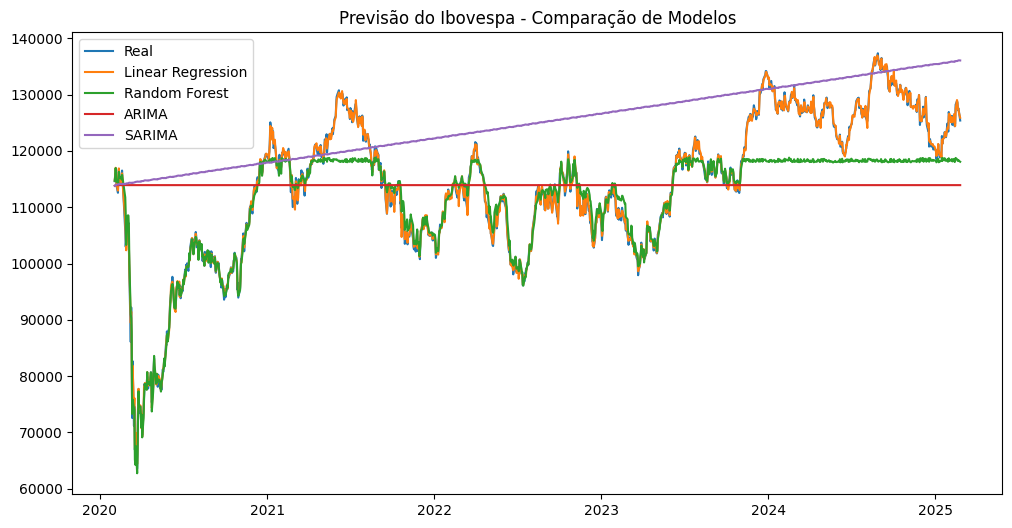

ValueError: Unable to coerce to Series, length must be 1: given 1260

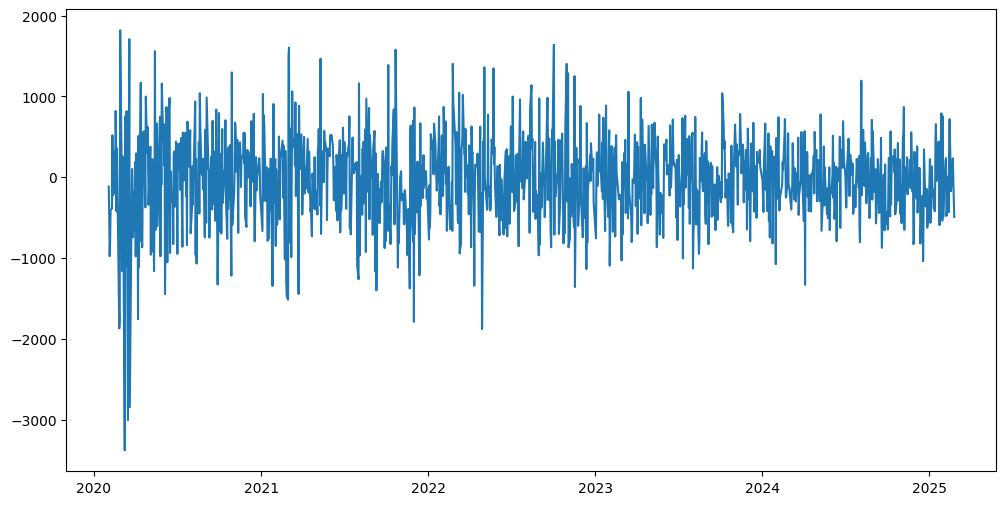

In [60]:
# Visualizar previsões vs real
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Real')
plt.plot(y_test.index, linear_predictions, label='Linear Regression')
plt.plot(y_test.index, rf_predictions, label='Random Forest')
plt.plot(y_test.index, arima_predictions, label='ARIMA')
plt.plot(y_test.index, sarima_predictions, label='SARIMA')
plt.legend()
plt.title('Previsão do Ibovespa - Comparação de Modelos')
plt.show()

# Análise de resíduos
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test - linear_predictions, label="Resíduos - Linear")
plt.plot(y_test.index, y_test - rf_predictions, label="Resíduos - Random Forest")
plt.plot(y_test.index, y_test - arima_predictions, label="Resíduos - ARIMA")
plt.plot(y_test.index, y_test - sarima_predictions, label="Resíduos - SARIMA")
plt.axhline(0, color='red', linestyle='--')
plt.legend()
plt.title('Resíduos da Previsão')
plt.show()